In [2354]:
import pandas as pd
import numpy as np
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.multicomp as multi

df = pd.read_excel('data/hg-in-fish.xlsx')

In [2355]:
# Defining the columns to keep in the updated dataframe
cols = ['Waterbody Name', 'Waterbody Type', 'Common Name', 'Sex', 'Fork Length (mm)', 'Total Length (mm)', 'Weight (g)', 'Maturity', 'Age (years)', 'Hg (mg/kg)']

In [2356]:
# Updating the dataframe
df = df[cols]

In [2357]:
# Identifying the columns needed to converted into numeric values
columns_to_convert = ['Fork Length (mm)', 'Total Length (mm)', 'Weight (g)', 'Age (years)', 'Hg (mg/kg)']

# Converting the columns to numeric data type and making all non-numeric values NaN
df[columns_to_convert] = df[columns_to_convert].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [2358]:
# Calculating the number of NaN values in the Hg (mg/kg) column
print('The number of null values in the Hg (mg/kg) column is', df['Hg (mg/kg)'].isnull().sum())

The number of null values in the Hg (mg/kg) column is 6


In [2359]:
# Dropping the NaN values
df.dropna(subset=['Hg (mg/kg)'], inplace=True)

In [2360]:
# Confirming that NaN values have been dropped
print('The number of null values in the Hg (mg/kg) column is', df['Hg (mg/kg)'].isnull().sum())

The number of null values in the Hg (mg/kg) column is 0


In [2361]:
# Checking to see the distribution of values in Hg (mg/kg)
hg_box = px.box(df['Hg (mg/kg)'])
hg_box.show()

This boxplot shows that the data contain many outliers that will affect the results of the analysis.

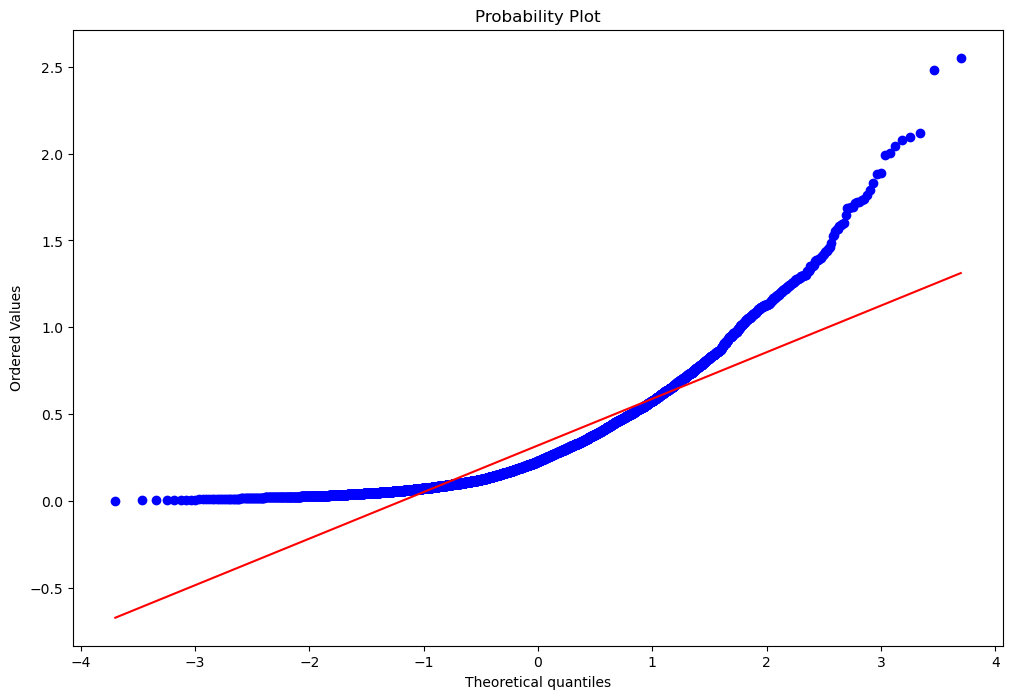

In [2362]:
# Creating a Q-Q probability plot to check for normality
plt.figure(figsize=(12, 8))
stats.probplot(df['Hg (mg/kg)'], plot=plt)
plt.show()

The Q-Q probability plot shows the data are not normally distributed. Performing a log10 transformation could help normalize the data and remove outliers

In [2363]:
# Performing a log10 transformation to remove outliers and normalize the data
df['log10_hg'] = np.log10(df['Hg (mg/kg)'])

# Ensuring there are no NaN values in the column
df.dropna(subset=['log10_hg'], inplace=True)

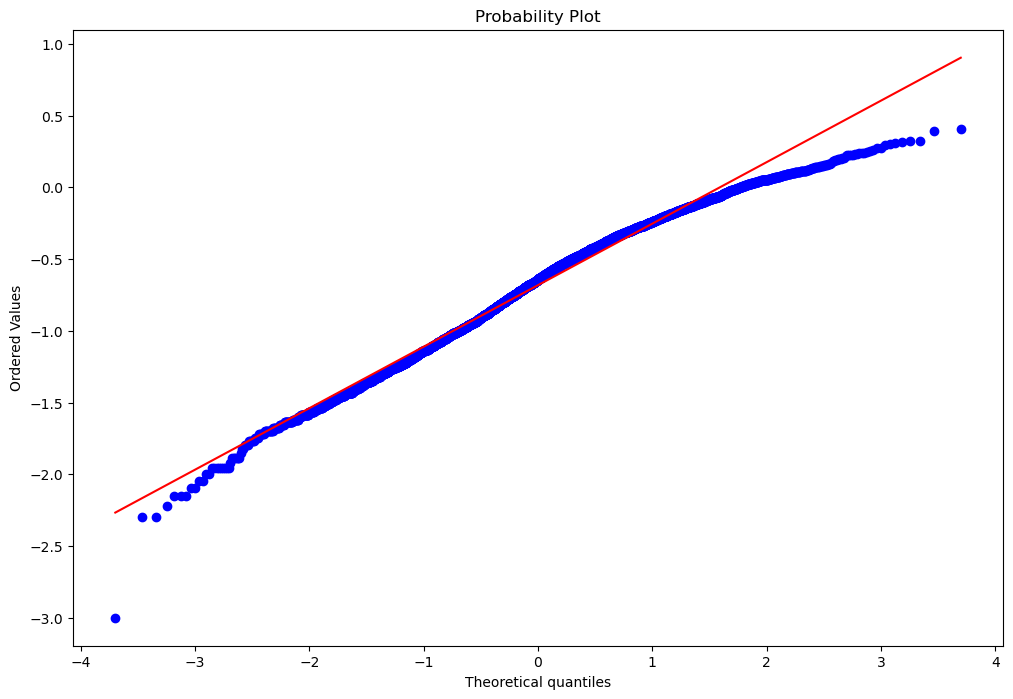

In [2364]:
# Creating a new Q-Q probability plot on the transformed data
plt.figure(figsize=(12, 8))
stats.probplot(df['log10_hg'], plot=plt)
plt.show()

The data appears to be approximately normal after the log10 transformation.

### Maturity Analysis

Hypothesis: There is a significant difference between the means of each group. Mature fish will have a larger concentration of Hg (mg/kg).

In [2365]:
# Creating a new dataframe that only contains the relevant data for the Maturity analysis
df_mat = df[['Maturity', 'log10_hg', 'Hg (mg/kg)']].dropna()

In [2366]:
# Removing the rows that contain 'Unknown' values
df_mat = df_mat[~df_mat.isin(['Unknown']).any(axis=1)]

In [2367]:
# Splitting the data into groups for the ANOVA analysis
group_mature = df_mat[df_mat['Maturity'] == 'Mature']['log10_hg']
group_immature = df_mat[df_mat['Maturity'] == 'Immature']['log10_hg']
group_triploid = df_mat[df_mat['Maturity'] == 'Triploid']['log10_hg']

In [2368]:
# Performing the one-way ANOVA
F_statistic, p_value = stats.f_oneway(group_mature, group_immature, group_triploid)
print('The F-statistic is', F_statistic)
print('The p-value is', p_value)

The F-statistic is 41.40078299162881
The p-value is 1.6378424324372194e-18


A one-way ANOVA was performed to compare the effect of maturity on Hg (mg/kg). A one-way ANOVA revealed that there was a statistically significant difference in Hg (mg/kg) between at least two groups *(F = 41.400, p < 0.001)*

In [2369]:
# Combine all groups into a single series to perform a Tukey HSD test
values = pd.concat([group_mature, group_immature, group_triploid])

# Create labels for each value
labels = ['Mature'] * len(group_mature) + ['Immature'] * len(group_immature) + ['Triploid'] * len(group_triploid)

In [2370]:
# Performing the Tukey HSD test
tukey = multi.MultiComparison(values, labels)
result = tukey.tukeyhsd()
print(result)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
Immature   Mature   0.1975    0.0    0.13  0.2651   True
Immature Triploid  -0.4152 0.0002  -0.659 -0.1715   True
  Mature Triploid  -0.6128    0.0 -0.8482 -0.3773   True
--------------------------------------------------------


Tukey’s HSD Test for multiple comparisons found that the mean value of Hg (mg/kg) was significantly different between Mature and Immature *(p < 0.001)*, Immature and Triploid *(p < 0.001)*, and Mature and Triploid *(p < 0.001)*

In [2371]:
# Plotting a boxplot to visualize the distribution of data for all groups
box = px.box(df_mat, x='Maturity', y='log10_hg')
box.show()

In [2372]:
# Calculate the mean 'Hg (mg/kg)' value for each maturity group and sort them from largest to smallest
mean_values = df_mat.groupby('Maturity')['Hg (mg/kg)'].mean().sort_values(ascending=False)
print(mean_values)

Maturity
Mature      0.369189
Immature    0.228384
Triploid    0.062333
Name: Hg (mg/kg), dtype: float64


Mature fish had the highest concentration of Hg (mg/kg), followed by Immature fish, and lastly Triploid fish.

### Weight Analysis

Hypothesis: As weight increases, the concentration of Hg (mg/kg) will significantly increase.

In [2373]:
# Creating a new dataframe with only the data needed for the weight analysis and dropping any NaN values
df_weight = df[['Weight (g)', 'log10_hg', 'Hg (mg/kg)']].dropna()

In [2374]:
# Performing a Pearson correlation
corr, p_value = stats.pearsonr(df_weight['log10_hg'], df_weight['Weight (g)'])
print(f'The Pearsons correlation is: {corr:.3f}')
print(f'The p-value is: {p_value:.3f}')

The Pearsons correlation is: 0.262
The p-value is: 0.000


A Pearson correlation coefficient was computed to assess the linear relationship between Weight (g) and Hg (mg/kg). There was a positive correlation between the two variables *(r = 0.262, p < 0.001)*.

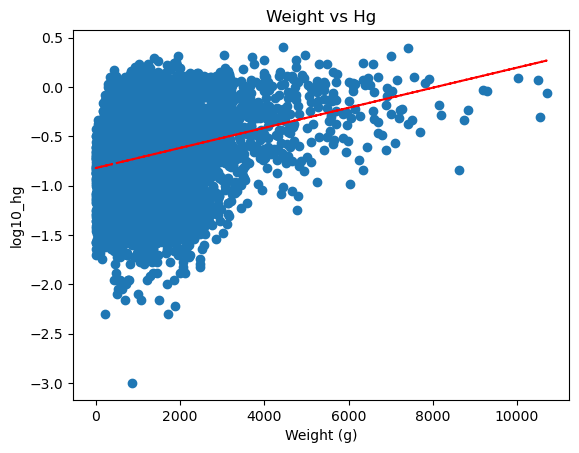

In [2375]:
# Creating a scatter plot with a trend line to visualize the linear relationship between Weight (g) and Hg (mg/kg)
x = df_weight['Weight (g)']
y = df_weight['log10_hg']

plt.scatter(x, y)

z = np.polyfit(x, y, deg=1)
p = np.poly1d(z)

plt.plot(x, p(x), 'r--')
plt.title('Weight vs Hg')
plt.xlabel('Weight (g)')
plt.ylabel('log10_hg')
plt.show()

In [2376]:
# Simple linear regression
y = df_weight['log10_hg']
x = df_weight['Weight (g)']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log10_hg   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     459.3
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           2.32e-98
Time:                        15:39:15   Log-Likelihood:                -3389.1
No. Observations:                6230   AIC:                             6782.
Df Residuals:                    6228   BIC:                             6796.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8213      0.008    -97.004      0.000      -0.838      -0.805
Weight (g)     0.0001   4.75e-06     21.430      0.000    9.25e-05       0.000
==============================================================================
Omnibus:                      158.068   Durbin-Watson:                   0.418
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.641
Skew:                          -0.390   Prob(JB):                     6.52e-37
Kurtosis:                       2.813   Cond. No.                     2.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [2377]:
# Undo the transformation of the constant for the linear regression model 
mb = np.exp(-0.8213)
print('The untransformed constant for the linear regression is', mb)

The untransformed constant for the linear regression is 0.43985946535867054


The equation is **Hg (mg/kg) = 0.440 + 0.0001 x Weight (g)** meaning every increase of weight by gram will result in a 0.0001 mg increase in the concentration of mercury (Hg). An increase of a kilogram would increase the concentration by 0.1 mg of mercury (Hg).

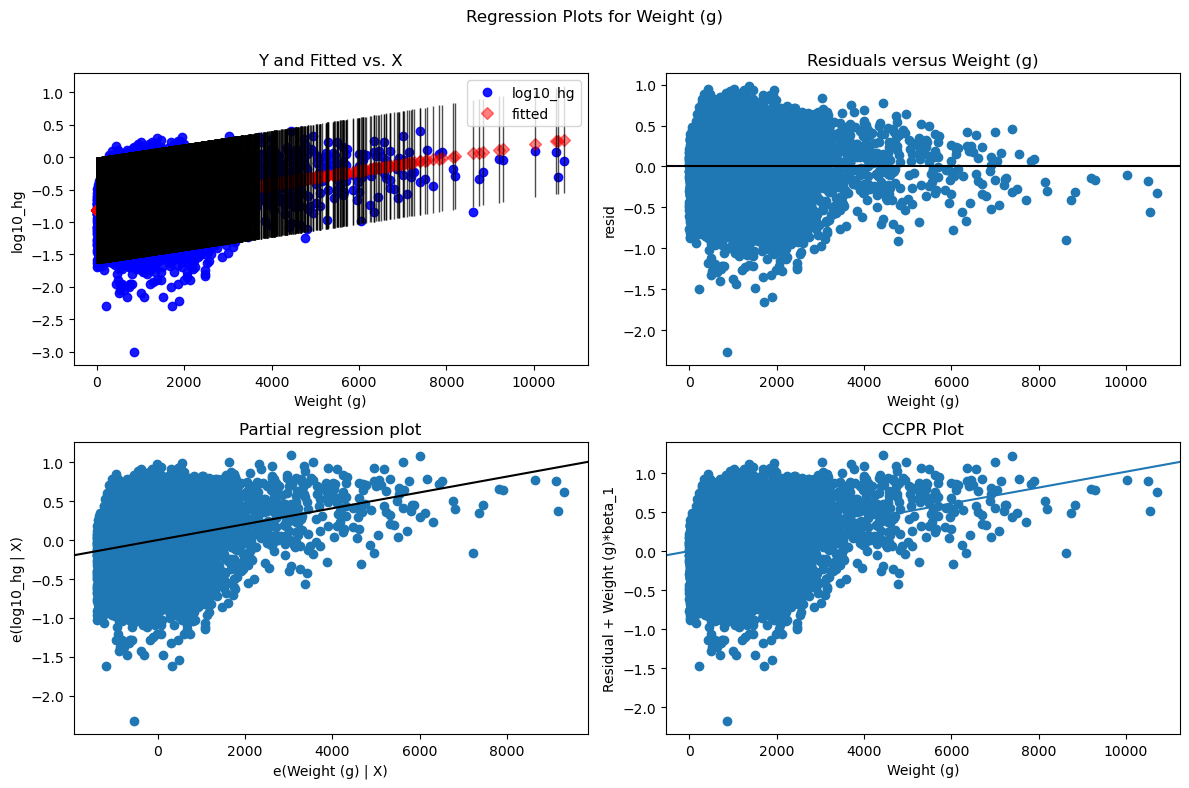

In [2378]:
# Creating regression plots
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_regress_exog(model, 'Weight (g)', fig=fig)

### Age Analysis

Hypothesis: As age increases, the concentration of Hg (mg/kg) will significantly increase.

In [2379]:
# Creating new dataframe and dropping any NaN values
df_age = df[['Age (years)', 'log10_hg']].dropna()

In [2380]:
# Performing a Pearson correlation
corr, p_value = stats.pearsonr(df_age['Age (years)'], df_age['log10_hg'])
print(f'The Pearsons correlation is: {corr:.3f}')
print(f'The p-value is: {p_value:.3f}')

The Pearsons correlation is: 0.177
The p-value is: 0.000


A Pearson correlation coefficient was computed to assess the linear relationship between Age (years) and Hg (mg/kg). There was a positive correlation between the two variables, *r = 0.177, p < 0.001*

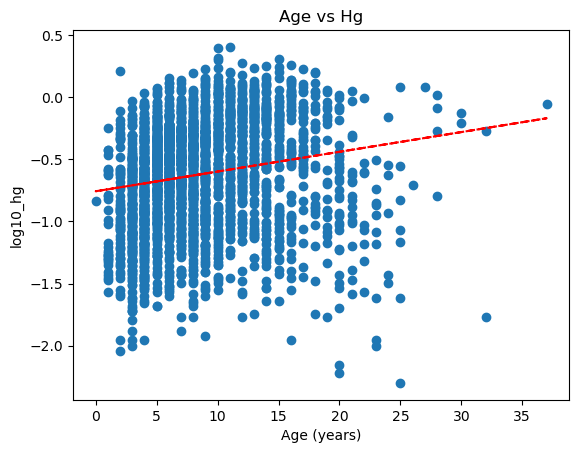

In [2381]:
# Creating a scatter plot with a trend line to visualize the linear relationship between Age (years) and Hg (mg/kg)
x = df_age['Age (years)']
y = df_age['log10_hg']

plt.scatter(x, y)

z = np.polyfit(x, y, deg=1)
p = np.poly1d(z)

plt.plot(x, p(x), 'r--')
plt.title('Age vs Hg')
plt.xlabel('Age (years)')
plt.ylabel('log10_hg')
plt.show()

In [2382]:
# Simple linear regression
y = df_age['log10_hg']
x = df_age['Age (years)']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log10_hg   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     96.46
Date:                Wed, 14 Aug 2024   Prob (F-statistic):           1.99e-22
Time:                        15:39:16   Log-Likelihood:                -1615.6
No. Observations:                2977   AIC:                             3235.
Df Residuals:                    2975   BIC:                             3247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7564      0.016    -48.415      0.000      -0.787      -0.726
Age (years)     0.0159      0.002      9.822      0.000       0.013       0.019
==============================================================================
Omnibus:                      157.277   Durbin-Watson:                   0.442
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.799
Skew:                          -0.600   Prob(JB):                     3.33e-40
Kurtosis:                       3.156   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [2383]:
# Undo the transformation of the constant for the linear regression model
mb = np.exp(-0.7564)
print('The untransformed constant for the linear regression is', mb)

The untransformed constant for the linear regression is 0.4693530602654414


The equation is **Hg (mg/kg) = 0.470 + 0.0159 x Age (years)** meaning every increase in age by one year will increase the concentration of mercury (Hg) by 0.0159 mg.

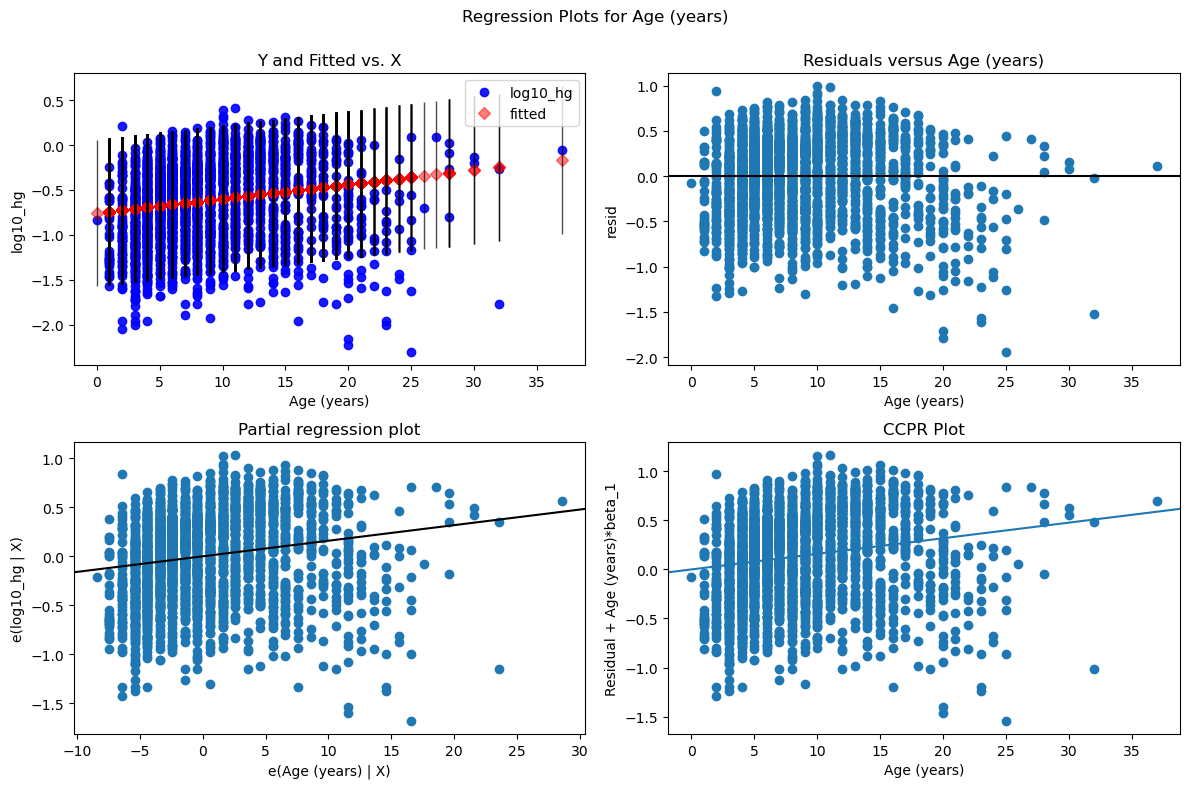

In [2384]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_regress_exog(model, "Age (years)", fig=fig)

### Sex Analysis

Hypothesis: There is no significant difference in the means of concentration of Hg (mg/kg) between male and female sexes.

In [2385]:
df_sex = df[['Sex', 'log10_hg', 'Hg (mg/kg)']].dropna()

In [2386]:
df_sex['Sex'].value_counts()

Sex
Female     2659
Male       1875
Unknown    1828
Female        4
Male          1
Name: count, dtype: int64

In [2387]:
df_sex['Sex'] = df_sex['Sex'].str.strip()

In [2388]:
df_sex['Sex'].value_counts()

Sex
Female     2663
Male       1876
Unknown    1828
Name: count, dtype: int64

In [2389]:
group_male = df_sex[df_sex['Sex'] == 'Male']['log10_hg']
group_female = df_sex[df_sex['Sex'] == 'Female']['log10_hg']

In [2390]:
t_statistic, p_value = stats.ttest_ind(group_male, group_female)

print("The t-statistic is:", t_statistic)
print("The p-value is:", p_value)

The t-statistic is: -3.726259662085424
The p-value is: 0.00019670709278671384


In [2391]:
df_sex = df_sex[~df_sex.isin(['Unknown']).any(axis=1)]

In [2392]:
mean_values = df_sex.groupby('Sex')['Hg (mg/kg)'].mean().sort_values(ascending=False)
print(mean_values)

Sex
Female    0.345320
Male      0.324227
Name: Hg (mg/kg), dtype: float64


### Waterbody Type Analysis

In [2393]:
df_type = df[['Waterbody Type', 'log10_hg', 'Hg (mg/kg)']].dropna()

In [2394]:
df_type['Waterbody Type'].value_counts()

Waterbody Type
Lake               4418
River              1230
Reservoir           685
Stormwater Pond      18
Canal                15
Lake                  1
Name: count, dtype: int64

In [2395]:
df_type['Waterbody Type'] = df_type['Waterbody Type'].str.strip()

In [2396]:
df_type['Waterbody Type'].value_counts()

Waterbody Type
Lake               4419
River              1230
Reservoir           685
Stormwater Pond      18
Canal                15
Name: count, dtype: int64

In [2397]:
waterbody_types = ['Lake', 'River', 'Reservoir', 'Stormwater Pond', 'Canal']
groups = {}

for waterbody in waterbody_types:
    groups[waterbody] = df_type[df_type['Waterbody Type'] == waterbody]['log10_hg'].dropna()

In [2398]:
group_river = groups['River']
group_lake = groups['Lake']
group_reservoir = groups['Reservoir']
group_stormwater = groups['Stormwater Pond']
group_canal = groups['Canal']

In [2399]:
stats.f_oneway(group_lake, group_river, group_reservoir, group_stormwater, group_canal)

F_onewayResult(statistic=70.76764635948483, pvalue=9.894113971031595e-59)

In [2400]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Create a new DataFrame with structure suitable for the Tukey HSD test
dataframes = []
groups = ['Lake', 'River', 'Reservoir', 'Stormwater Pond', 'Canal']
for group in groups:
    df_type_group = df_type[df_type['Waterbody Type'] == group][['log10_hg']].copy()
    df_type_group['group'] = group
    dataframes.append(df_type_group)
tukey_df_type = pd.concat(dataframes)

# Drop NaN values to prevent errors
tukey_df_type = tukey_df_type.dropna()

# Apply the Tukey HSD test
results = pairwise_tukeyhsd(endog=tukey_df_type['log10_hg'], groups=tukey_df_type['group'], alpha=0.05)
print(results)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1       group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
    Canal            Lake   0.3094 0.0374  0.0113  0.6075   True
    Canal       Reservoir   0.5622    0.0  0.2614  0.8631   True
    Canal           River   0.2671 0.1064 -0.0323  0.5665  False
    Canal Stormwater Pond  -0.2125 0.6024 -0.6155  0.1905  False
     Lake       Reservoir   0.2528    0.0  0.2055  0.3001   True
     Lake           River  -0.0423 0.0164 -0.0794 -0.0051   True
     Lake Stormwater Pond  -0.5219    0.0 -0.7941 -0.2497   True
Reservoir           River  -0.2951    0.0   -0.35 -0.2401   True
Reservoir Stormwater Pond  -0.7747    0.0 -1.0499 -0.4995   True
    River Stormwater Pond  -0.4796    0.0 -0.7533  -0.206   True
----------------------------------------------------------------


The means are all significantly different from each other except for between Canal & River and Canal & Stormwater Pond

In [2401]:
# Calculate the mean Hg (mg/kg) value for each water body type (group) and sort the means largest to smallest
mean_values = df_type.groupby('Waterbody Type')['Hg (mg/kg)'].mean().sort_values(ascending=False)
print(mean_values)

Waterbody Type
Reservoir          0.480009
Lake               0.310847
River              0.267985
Canal              0.120333
Stormwater Pond    0.062333
Name: Hg (mg/kg), dtype: float64


In [2402]:
# Plotting a boxplot to visualize the distribution of data for all groups
waterbody_means = px.box(df_type, x='Waterbody Type', y='log10_hg')
waterbody_means.show()

### Waterbody Name Analysis

In [2403]:
df['Waterbody Name'] = df['Waterbody Name'].str.strip()

In [2404]:
# Creating new dataframe with only relevant data and dropping any NaN values
df_name = df[['Waterbody Name', 'Hg (mg/kg)']].dropna()

In [2405]:
df['Waterbody Name'].value_counts()

Waterbody Name
Willow Creek                                             459
Moose Lake                                               196
Twin Valley Reservoir                                    142
Shiningbank Lake                                         130
Pigeon Lake                                              128
                                                        ... 
North Saskatchewan River (within Edmonton)                 5
Loon River                                                 4
Hay River                                                  4
North Saskatchewan River (between Edmonton and Devon)      2
Lac La Biche                                               1
Name: count, Length: 142, dtype: int64

In [2406]:
# Calculating the means for each group and sorting them from largest to smallest
sorted_grouped = df_name.groupby('Waterbody Name')['Hg (mg/kg)'].mean().sort_values(ascending=False)
print(sorted_grouped)

Waterbody Name
Rolling Hills Lake (Rolling Hills Reservoir)       1.088154
Narrow Lake                                        0.897400
Clear Lake (Barnes Lake)                           0.886625
Ironwood Lake                                      0.861467
Burnstick Lake                                     0.817967
                                                     ...   
Richardson Lake                                    0.068050
Athabasca River (between Hinton and Whitecourt)    0.066845
County Sportsplex Pond                             0.062333
Snipe Lake                                         0.049123
McLeod Lake (Carson Lake)                          0.048857
Name: Hg (mg/kg), Length: 142, dtype: float64


### Common Name

In [2407]:
df['Common Name'] = df['Common Name'].str.strip()

In [2408]:
df_common = df[['Common Name', 'log10_hg', 'Hg (mg/kg)']].dropna()

In [2409]:
df_common['Common Name'].value_counts()

Common Name
Walleye               2042
Northern Pike         2014
Lake Whitefish         932
White Sucker           394
Longnose Sucker        154
Mountain Whitefish     151
Lake Trout             104
Yellow Perch            92
Burbot                  89
Rainbow Trout           79
Brook Trout             65
Goldeye                 60
Cisco                   54
Sauger                  43
Shorthead Redhorse      25
Mooneye                 18
Lake Chub (Cisco)       16
Brown Trout             13
Longnose Dace           10
Trout Perch              9
Cutthroat Trout          2
Flathead Chub            1
Name: count, dtype: int64

### Common Name Analysis

In [2410]:
sorted_grouped = df_common.groupby('Common Name')['Hg (mg/kg)'].mean().sort_values(ascending=False)
print(sorted_grouped)

Common Name
Sauger                0.747163
Goldeye               0.474050
Walleye               0.461861
Shorthead Redhorse    0.442280
Northern Pike         0.361282
Lake Trout            0.312885
Mooneye               0.302333
Burbot                0.301225
White Sucker          0.198393
Flathead Chub         0.174000
Lake Chub (Cisco)     0.153250
Longnose Dace         0.141100
Brook Trout           0.139600
Longnose Sucker       0.134968
Brown Trout           0.096154
Cisco                 0.090796
Lake Whitefish        0.089089
Yellow Perch          0.088989
Mountain Whitefish    0.077987
Trout Perch           0.075667
Rainbow Trout         0.074000
Cutthroat Trout       0.043500
Name: Hg (mg/kg), dtype: float64


In [2411]:
# Creating a new dataframe that contains the common names and their mean Hg (mg/kg) concentration
df_sorted_grouped = sorted_grouped.to_frame().reset_index()

In [2412]:
def range_based_rules(val):
    if val < 0.2:
        return 'No Consumption Advice'
    elif 0.2 <= val < 0.5:
        return 'Consumption Limit'
    else:
        return 'Avoid Consumption'

df_sorted_grouped['Consumption Advice'] = df_sorted_grouped['Hg (mg/kg)'].apply(range_based_rules)

In [2413]:
print(df_sorted_grouped)

           Common Name  Hg (mg/kg)     Consumption Advice
0               Sauger    0.747163      Avoid Consumption
1              Goldeye    0.474050      Consumption Limit
2              Walleye    0.461861      Consumption Limit
3   Shorthead Redhorse    0.442280      Consumption Limit
4        Northern Pike    0.361282      Consumption Limit
5           Lake Trout    0.312885      Consumption Limit
6              Mooneye    0.302333      Consumption Limit
7               Burbot    0.301225      Consumption Limit
8         White Sucker    0.198393  No Consumption Advice
9        Flathead Chub    0.174000  No Consumption Advice
10   Lake Chub (Cisco)    0.153250  No Consumption Advice
11       Longnose Dace    0.141100  No Consumption Advice
12         Brook Trout    0.139600  No Consumption Advice
13     Longnose Sucker    0.134968  No Consumption Advice
14         Brown Trout    0.096154  No Consumption Advice
15               Cisco    0.090796  No Consumption Advice
16      Lake W

These guidelines are taken from the report **Government of Alberta. (2019).** ***Fish Consumption Guidance: Mercury in Fish***

### Fork Length Analysis

Hypothesis: As Fork Length increases, the concentration of Hg (mg/kg) will significantly increase.

In [2414]:
df_fork = df[['Fork Length (mm)', 'log10_hg', 'Hg (mg/kg)']].dropna()

In [2415]:
corr, p_value = stats.pearsonr(df_fork['Fork Length (mm)'], df_fork['log10_hg'])
print(f'The Pearsons correlation is: {corr:.3f}')
print(f'The p-value is: {p_value:.3f}')

The Pearsons correlation is: 0.375
The p-value is: 0.000


A Pearson correlation coefficient was computed to assess the linear relationship between Fork Length (mm) and Hg (mg/kg). There was a positive correlation between the two variables *(r = 0.375, p < 0.001)*.

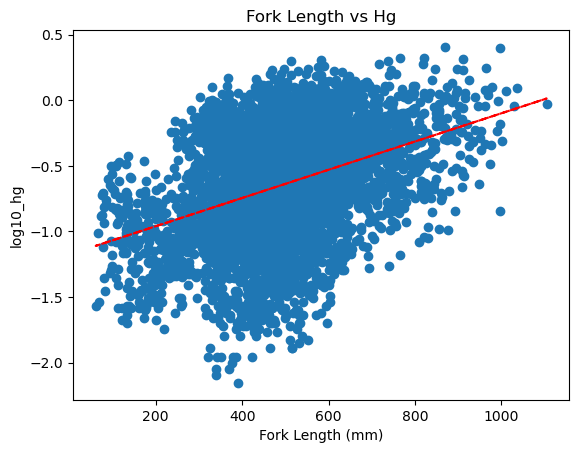

In [2416]:
# Creating a scatter plot with a trend line to visualize the linear relationship between Age (years) and Hg (mg/kg)
x = df_fork['Fork Length (mm)']
y = df_fork['log10_hg']

plt.scatter(x, y)

z = np.polyfit(x, y, deg=1)
p = np.poly1d(z)

plt.plot(x, p(x), 'r--')
plt.title('Fork Length vs Hg')
plt.xlabel('Fork Length (mm)')
plt.ylabel('log10_hg')
plt.show()

In [2417]:
# Simple linear regression
y = df_fork['log10_hg']
x = df_fork['Fork Length (mm)']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log10_hg   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     863.5
Date:                Wed, 14 Aug 2024   Prob (F-statistic):          6.35e-176
Time:                        15:39:17   Log-Likelihood:                -2548.8
No. Observations:                5284   AIC:                             5102.
Df Residuals:                    5282   BIC:                             5115.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1755      0.019    -62.443      0.000      -1.212      -1.139
Fork Length (mm)     0.0011   3.66e-05     29.385      0.000       0.001       0.001
==============================================================================
Omnibus:                      108.074   Durbin-Watson:                   0.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.248
Skew:                          -0.336   Prob(JB):                     1.15e-24
Kurtosis:                       2.776   Cond. No.                     1.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [2418]:
# Undo the transformation of the constant for the linear regression model
mb = np.exp(-1.1755)
print('The untransformed constant for the linear regression is', mb)

The untransformed constant for the linear regression is 0.3086646087941154


The equation is **Hg (mg/kg) = 0.309 + 0.0011 x Fork Length (mm)** meaning every increase in Fork Length by one millimetre will increase the concentration of mercury (Hg) by 0.0011 mg.

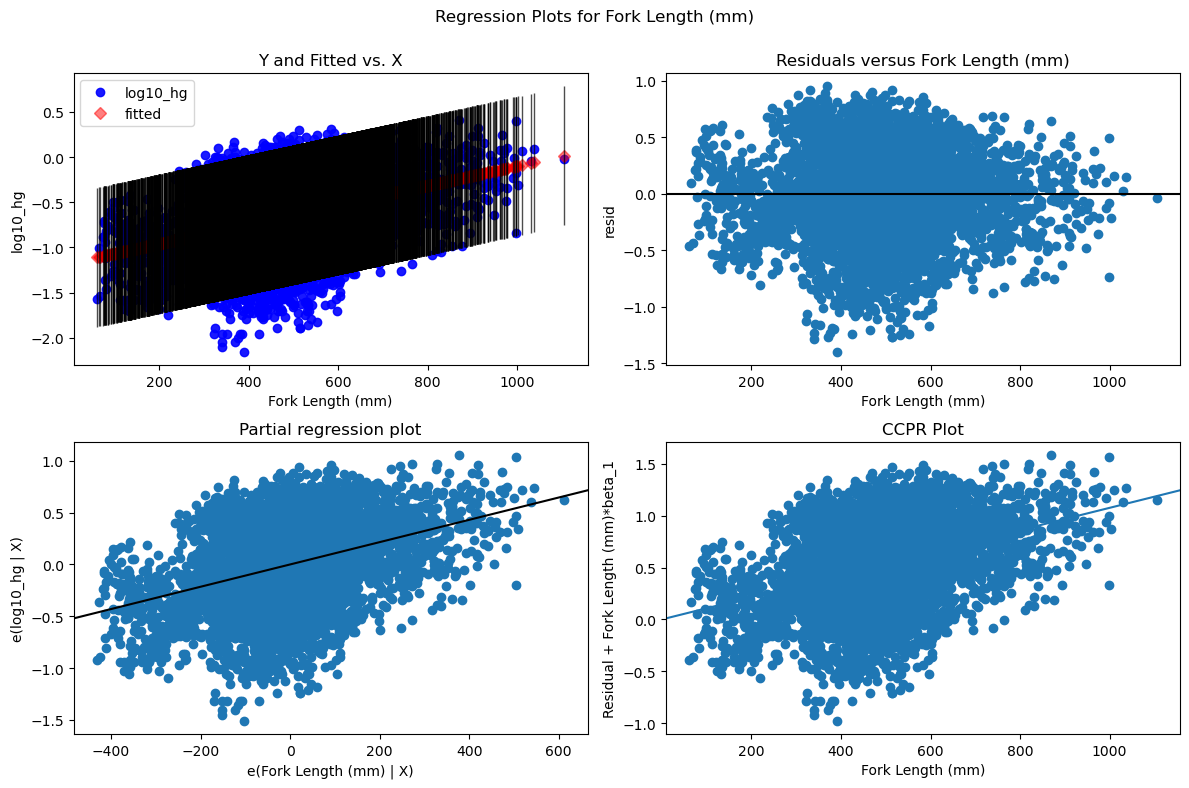

In [2419]:
fig = plt.figure(figsize=(12, 8))
fig = sm.graphics.plot_regress_exog(model, "Fork Length (mm)", fig=fig)

### Total Length Analysis

In [2420]:
df_total = df[['Total Length (mm)', 'log10_hg', 'Hg (mg/kg)']].dropna()

In [2422]:
corr, p_value = stats.pearsonr(df_total['Total Length (mm)'], df_total['log10_hg'])
print(f'The Pearsons correlation is: {corr:.3f}')
print(f'The p-value is: {p_value:.3f}')

The Pearsons correlation is: 0.356
The p-value is: 0.000


### References

Alberta Health Environmental Public Health Science Team. (n.d.). Chemical Monitoring in Local Foods: Mercury in Fish—Open Government. Retrieved August 14, 2024, from https://open.alberta.ca/opendata/chemical-monitoring-in-local-foods-mercury-in-fish

Government of Alberta. (2019). *Fish Consumption Guidance: Mercury in Fish.* Environmental
Public Health Science Unit, Health Protection Branch, Public Health and Compliance
Division, Alberta Health. Edmonton, Alberta.